In [3]:
# from IPython.core.display import display,HTML
# display(HTML('<style> div.prompt {display:default} </style>'))

In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [5]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'ladyns.optimize.core' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ladyns/optimize/core.cpython-37m-x86_64-linux-gnu.so'>

# 0. simulation from model + LFP

In [45]:
save_dir = "../temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## load data

In [7]:
data_dir = "../data/"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [8]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0)[:,:,:100:2].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0)[:,:,:100:2].T]

In [9]:
data[0].shape, data[1].shape

((50, 25, 3000), (50, 25, 3000))

In [10]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
obs_trial = data[0].shape[2]

## load LaDynS run on data

In [11]:
result_exp = np.load('%s/result_exp.npz'%save_dir)
Sigma_exp = result_exp['Sigma_est']
weight_exp = result_exp['weight_est']

## cross precision

In [12]:
num_blobs = 3

In [13]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [14]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

Text(0.5, 0, 'series 2 at time $s$')

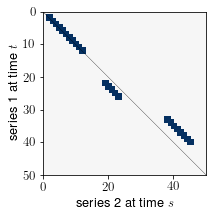

In [16]:
plt.figure(figsize=(3,3))
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

## latent direction

In [21]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [22]:
weights_exp = [np.array(weight_exp[:num_time]),
               np.array(weight_exp[num_time:])]
betas_exp = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_exp)]

## latent precision

In [23]:
sighat = Sigma_exp.copy()
sighat_1 = sighat[:num_time,:num_time]
sighat_2 = sighat[num_time:,num_time:]

In [24]:
Y_mm_1 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_1[np.arange(1,num_time), np.arange(0,num_time-1)])))])
Y_mm_2 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_2[np.arange(1,num_time), np.arange(0,num_time-1)])))])

In [25]:
sigmm_1 = np.exp(-(np.square(Y_mm_1[:,None] - Y_mm_1[None,:])/2))
sigmm_2 = np.exp(-(np.square(Y_mm_2[:,None] - Y_mm_2[None,:])/2))

In [26]:
precs_auto = [linalg.inv(S + 0.5 * np.eye(num_time))
              for S in [sigmm_1, sigmm_2]] 

In [32]:
snr = np.array([0.006, -0.006, 0.006])
prec_latent = np.array(np.block([
    [precs_auto[0], -np.sum(snr[:,None,None]*H0,0)],
    [-np.sum(snr[:,None,None]*H0,0).T, precs_auto[1]]
]))
cov_latent = linalg.inv(prec_latent)

In [33]:
cov_latent = cov_latent + np.real(np.min(linalg.eig(Sigma_exp)[0]) - np.min(linalg.eig(cov_latent)[0]))*np.eye(2*num_time)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

Text(0.5, 0, 'series 2 at time $s$')

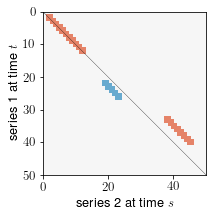

In [131]:
plt.figure(figsize=(4,3))
ldn.imshow(-np.sum(snr[:,None,None]*H0,0), time=[0,50], identity=True)
plt.clim(-0.012,0.012)
#cbar = plt.colorbar(ticks=[-0.012, -0.006, 0.0, 0.006, 0.012])
#cbar.ax.set_yticklabels([r'-12e-3','-6e-3','0','6e-3',r'12e-3'])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

## simulate

In [37]:
obs_trial = data[0].shape[2]
num_trial = 3000

In [38]:
dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=False)]
         for dat, dim in zip(data, dims)]
ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
          for dir_i, dumm in zip(weights_exp, dummy)]

# cov_ldummy = np.cov(ldummy[0], ldummy[1])
# sd_ldummy = np.sqrt(np.diag(cov_ldummy))

latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

pops = [dummy[0] + betas_exp[0][:,:,None] * (latent_variables[:num_time,None,:]-ldummy[0][:,None,:]),
        dummy[1] + betas_exp[1][:,:,None] * (latent_variables[num_time:,None,:]-ldummy[1][:,None,:])]

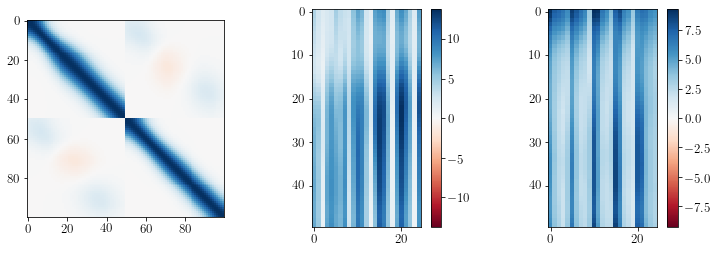

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); ldn.imshow(chol_latent.T @ chol_latent)
plt.subplot(1,3,2); ldn.imshow(np.array(betas_exp[0])); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(np.array(betas_exp[1])); plt.colorbar()

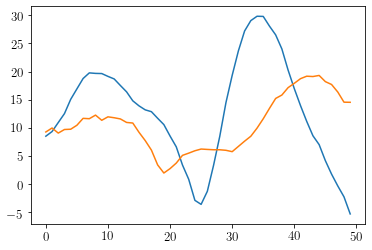

In [43]:
plt.plot(pops[0][:,0,0])
plt.plot(pops[1][:,0,0])

# 1. crossvalidation

In [46]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [47]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [48]:
rec_time = [0,50]

In [49]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

## RIC

In [50]:
num_cv = 10

In [51]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [pops[0], pops[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 67.550867, change: 0.081538, lapse: 1.552175
2-th iter, nll: 67.465672, change: 0.007751, lapse: 1.518086
3-th iter, nll: 67.401743, change: 0.004581, lapse: 1.526881
4-th iter, nll: 67.350904, change: 0.003846, lapse: 1.538853
5-th iter, nll: 67.309259, change: 0.003325, lapse: 1.509336
6-th iter, nll: 67.274512, change: 0.002909, lapse: 1.545210
7-th iter, nll: 67.245121, change: 0.002590, lapse: 1.384163
8-th iter, nll: 67.219993, change: 0.002342, lapse: 1.337551
9-th iter, nll: 67.198327, change: 0.002138, lapse: 1.354440
10-th iter, nll: 67.179516, change: 0.001963, lapse: 1.325706
11-th iter, nll: 67.163087, change: 0.001806, lapse: 1.304737
12-th iter, nll: 67.148666, change: 0.001665, lapse: 1.292227
13-th iter, nll: 67.135951, change: 0.001538, lapse: 1.269806
14-th iter, nll: 67.124696, change: 0.001423, lapse: 1.264445
15-th iter, nll: 67.114699, change: 0.001319, lapse: 1.252051
16-th iter, nll: 67.105793, change: 0.001224, lapse: 1.264978
17-th iter, nll: 

2-th iter, nll: 67.026437, change: 0.000266, lapse: 1.175334
1-th iter, nll: 67.024786, change: 0.051957, lapse: 1.252309
2-th iter, nll: 67.023862, change: 0.000233, lapse: 1.167641
1-th iter, nll: 67.078558, change: 0.000916, lapse: 1.153101
1-th iter, nll: 67.073374, change: 0.000854, lapse: 1.481762
1-th iter, nll: 67.064464, change: 0.006903, lapse: 1.535015
2-th iter, nll: 67.060636, change: 0.000692, lapse: 1.417883
1-th iter, nll: 67.057069, change: 0.020658, lapse: 1.408698
2-th iter, nll: 67.053913, change: 0.000600, lapse: 1.184988
1-th iter, nll: 67.050565, change: 0.029586, lapse: 1.213659
2-th iter, nll: 67.047945, change: 0.000519, lapse: 1.249043
1-th iter, nll: 67.044863, change: 0.036095, lapse: 1.248089
2-th iter, nll: 67.042679, change: 0.000446, lapse: 1.204922
1-th iter, nll: 67.039853, change: 0.039509, lapse: 1.221651
2-th iter, nll: 67.038026, change: 0.000389, lapse: 1.178314
1-th iter, nll: 67.035440, change: 0.043940, lapse: 1.248735
2-th iter, nll: 67.03390

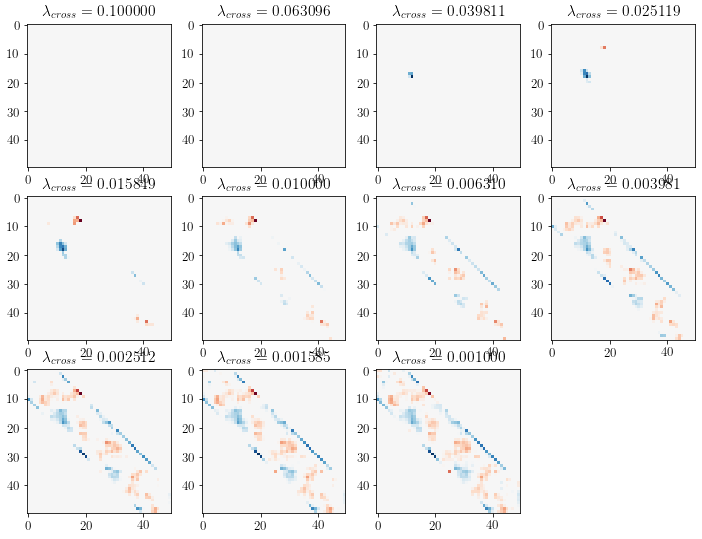

In [52]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [53]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

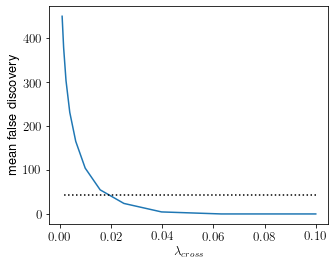

In [54]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

# cv result

In [55]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [56]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.025118864315095805, 0.0, 0.5, 0.0)

In [57]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

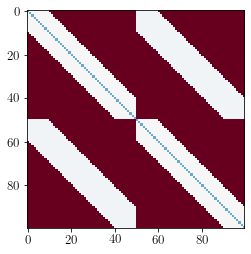

In [58]:
ldn.imshow(lambda_graph)

In [60]:
Omega_est, Sigma_est, latent_est, weight_est \
= ldn.fit(pops, lambda_diag, lambda_cross, offset_cross,
          lambda_auto, offset_auto, 
          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 67.518531, change: 0.081562, lapse: 1.532374
2-th iter, nll: 67.431566, change: 0.007746, lapse: 1.760342
3-th iter, nll: 67.366130, change: 0.004659, lapse: 1.725994
4-th iter, nll: 67.314020, change: 0.003930, lapse: 1.518997
5-th iter, nll: 67.271305, change: 0.003396, lapse: 1.540370
6-th iter, nll: 67.235652, change: 0.002968, lapse: 1.480772
7-th iter, nll: 67.205496, change: 0.002638, lapse: 1.462235
8-th iter, nll: 67.179724, change: 0.002381, lapse: 1.433115
9-th iter, nll: 67.157516, change: 0.002167, lapse: 1.401014
10-th iter, nll: 67.138250, change: 0.001983, lapse: 1.397845
11-th iter, nll: 67.121442, change: 0.001819, lapse: 1.399273
12-th iter, nll: 67.106707, change: 0.001672, lapse: 1.359378
13-th iter, nll: 67.093732, change: 0.001540, lapse: 1.379606
14-th iter, nll: 67.082266, change: 0.001420, lapse: 1.408046
15-th iter, nll: 67.072099, change: 0.001312, lapse: 1.572960
16-th iter, nll: 67.063056, change: 0.001215, lapse: 1.472789
17-th iter, nll: 

In [62]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est

## plots

Text(0.5, 0, 'series 2 at time $s$')

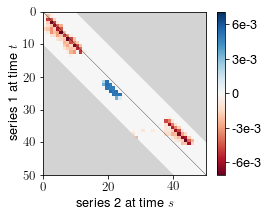

In [65]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[-6e-3, -3e-3, 0, 3e-3, 6e-3,])
cbar.ax.set_yticklabels(['-6e-3','-3e-3','0', '3e-3', '6e-3'])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

Text(0.5, 0, 'series 2 at time $s$')

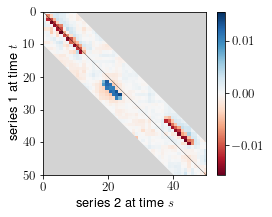

In [66]:
plt.figure(figsize=(4,3))
ldn.imshow(dspr_est[:num_time,num_time:], time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

plt.colorbar()
# cbar = plt.colorbar(ticks=[-6e-3, -3e-3, 0, 3e-3, 6e-3,])
# cbar.ax.set_yticklabels(['-6e-3','-3e-3','0', '3e-3', '6e-3'])

plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

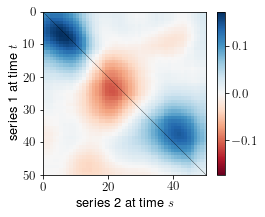

In [67]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=[0,50], identity=True)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
plt.colorbar()

# 2. Permutation test

In [68]:
num_perm = 200

In [69]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [70]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 67.193318, change: 0.138525, lapse: 1.767269
2-th iter, nll: 67.174472, change: 0.002981, lapse: 1.447206
3-th iter, nll: 67.160325, change: 0.001814, lapse: 1.403445
4-th iter, nll: 67.148610, change: 0.001665, lapse: 1.380488
5-th iter, nll: 67.138515, change: 0.001644, lapse: 1.366795
6-th iter, nll: 67.129629, change: 0.001627, lapse: 1.363249
7-th iter, nll: 67.121699, change: 0.001603, lapse: 1.348669
8-th iter, nll: 67.114555, change: 0.001563, lapse: 1.352028
9-th iter, nll: 67.108075, change: 0.001514, lapse: 1.355350
10-th iter, nll: 67.102167, change: 0.001460, lapse: 1.334562
11-th iter, nll: 67.096759, change: 0.001405, lapse: 1.343373
12-th iter, nll: 67.091794, change: 0.001349, lapse: 1.302384
13-th iter, nll: 67.087222, change: 0.001295, lapse: 1.311366
14-th iter, nll: 67.083004, change: 0.001244, lapse: 1.315280
15-th iter, nll: 67.079104, change: 0.001195, lapse: 1.327246
16-th iter, nll: 67.075492, change: 0.001149, lapse: 1.299331
17-th iter, nll: 

2-th iter, nll: 67.019803, change: 0.000062, lapse: 0.997072
1-th iter, nll: 67.019945, change: 0.020562, lapse: 1.034539
2-th iter, nll: 67.019935, change: 0.000078, lapse: 1.021163
1-th iter, nll: 67.018753, change: 0.043690, lapse: 1.065082
2-th iter, nll: 67.018740, change: 0.000141, lapse: 1.034659
1-th iter, nll: 67.020059, change: 0.037606, lapse: 1.061793
2-th iter, nll: 67.020050, change: 0.000060, lapse: 1.014544
1-th iter, nll: 67.020009, change: 0.018031, lapse: 1.058307
2-th iter, nll: 67.020001, change: 0.000056, lapse: 0.996073
1-th iter, nll: 67.019903, change: 0.021889, lapse: 1.040173
2-th iter, nll: 67.019894, change: 0.000072, lapse: 1.024359
1-th iter, nll: 67.019190, change: 0.031635, lapse: 1.083940
2-th iter, nll: 67.019181, change: 0.000093, lapse: 1.052058
1-th iter, nll: 67.019798, change: 0.031124, lapse: 1.037673
2-th iter, nll: 67.019790, change: 0.000069, lapse: 1.008445
1-th iter, nll: 67.019985, change: 0.019765, lapse: 1.075892
2-th iter, nll: 67.01997

1-th iter, nll: 67.019882, change: 0.026934, lapse: 1.154446
2-th iter, nll: 67.019881, change: 0.000040, lapse: 0.990470
1-th iter, nll: 67.019421, change: 0.023904, lapse: 1.093343
2-th iter, nll: 67.019419, change: 0.000071, lapse: 1.031755
1-th iter, nll: 67.020043, change: 0.021061, lapse: 1.048084
2-th iter, nll: 67.020042, change: 0.000017, lapse: 1.029771
1-th iter, nll: 67.019046, change: 0.025985, lapse: 1.167231
2-th iter, nll: 67.019044, change: 0.000082, lapse: 1.040805
1-th iter, nll: 67.019990, change: 0.023166, lapse: 1.071048
2-th iter, nll: 67.019990, change: 0.000026, lapse: 1.045703
1-th iter, nll: 67.019452, change: 0.017760, lapse: 1.058580
2-th iter, nll: 67.019451, change: 0.000053, lapse: 0.982572
1-th iter, nll: 67.020025, change: 0.020525, lapse: 1.056847
2-th iter, nll: 67.020025, change: 0.000023, lapse: 1.034619
1-th iter, nll: 67.019830, change: 0.015837, lapse: 1.136322
2-th iter, nll: 67.019830, change: 0.000076, lapse: 1.070358
1-th iter, nll: 67.02000

2-th iter, nll: 67.019619, change: 0.000050, lapse: 1.179779
1-th iter, nll: 67.019150, change: 0.022849, lapse: 1.161537
2-th iter, nll: 67.019148, change: 0.000068, lapse: 1.276538
1-th iter, nll: 67.019846, change: 0.032345, lapse: 1.165921
2-th iter, nll: 67.019845, change: 0.000079, lapse: 1.045084
1-th iter, nll: 67.018775, change: 0.031846, lapse: 1.203400
2-th iter, nll: 67.018773, change: 0.000084, lapse: 1.054724
1-th iter, nll: 67.018610, change: 0.043608, lapse: 1.186512
2-th iter, nll: 67.018606, change: 0.000154, lapse: 1.090283
1-th iter, nll: 67.019704, change: 0.039889, lapse: 1.169011
2-th iter, nll: 67.019703, change: 0.000050, lapse: 1.222890
1-th iter, nll: 67.019704, change: 0.020084, lapse: 1.153149
2-th iter, nll: 67.019703, change: 0.000054, lapse: 1.043860


# 3. Inference by STAR

In [72]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
       np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [71]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm @ Sigmas_perm @ Omegas_perm

In [76]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [79]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

In [82]:
R, fdp, score, mask = \
    inf.STAR_seq_step(pval_est, prop_carve = 0.05, alphas = [alpha],
                      sigma=1, mux_init=-np.log(alpha), roi=roi)
rej_STAR = mask[0]

## plots

Text(0.5, 0, 'series 2 at time $s$')

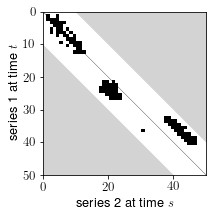

In [134]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est > 0.01, cmap='gray', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

# cbar = plt.colorbar(ticks=[0, 0.01])
# cbar.ax.set_yticklabels(['0.00','$>$ 0.01'])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

[Text(1, 0, '-12e-3'),
 Text(1, 0, '-6e-3'),
 Text(1, 0, '0'),
 Text(1, 0, '6e-3'),
 Text(1, 0, '12e-3')]

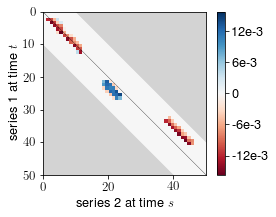

In [129]:
plt.figure(figsize=(4,3))
ldn.imshow(rej_STAR * dspr_est[:num_time,num_time:], time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]); plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
cbar = plt.colorbar(ticks=[-0.012, -0.006, 0.0, 0.006, 0.012])
cbar.ax.set_yticklabels([r'-12e-3','-6e-3','0','6e-3',r'12e-3'])

Text(0, 0.5, 'V4 at time $s$ sec.')

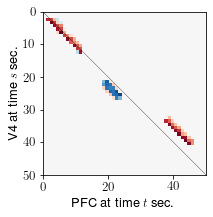

In [86]:
plt.figure(figsize=(3,3))
ldn.imshow(rej_STAR * dspr_est[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

# 4. Inference by excursion test

In [97]:
ths_nv = 0.05

In [98]:
rej_nv_est = pval_est < ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [99]:
rbs_nv_perm = np.zeros((num_perm, num_time, num_time))
nbs_nv_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm].copy(); iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rbs_nv_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nbs_nv_perm[iter_perm] = iter_blob

In [100]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rbs_nv_perm, nbs_nv_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [101]:
ths_roi_nv = np.quantile(mrois_nv_perm, 0.95)

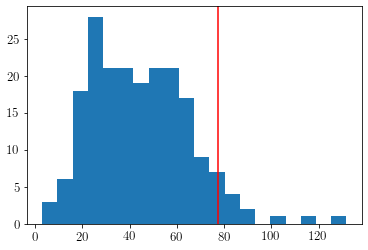

In [102]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [103]:
rb_nv_est = np.zeros((num_time, num_time))

mask_cp = rej_nv_est.copy(); iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rb_nv_est[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
nb_nv_est = iter_blob

In [104]:
rois_nv_est = np.zeros(nb_nv_est+1)
for iter_blob in range(1, nb_nv_est+1):
    rois_nv_est[iter_blob] = np.sum(-np.log(pval_est[rb_nv_est == iter_blob]))

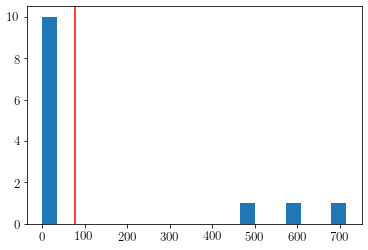

In [105]:
plt.hist(rois_nv_est, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [108]:
p_rois_nv = np.mean(rois_nv_est <= mrois_nv_perm[:,None], 0); p_rois_nv

array([1.   , 0.   , 0.955, 1.   , 0.985, 0.99 , 0.995, 0.995, 0.   ,
       0.99 , 0.   , 0.99 , 0.985])

## plot

Text(0.5, 0, 'series 2 at time $s$')

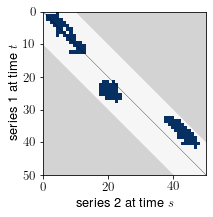

In [107]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rb_nv_est, np.where(rois_nv_est > ths_roi_nv)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')